Importing dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2

I am using tf.keras.preprocessing.dataset_from_image_directory to load the data. Spliting the data: 80% training 20% validation

In [2]:
img_height = 150
img_width = 150
batch_size = 32

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/clothing-dataset-small-master/train", 
                                                                   labels='inferred', 
                                                                   seed=123, 
                                                                   batch_size=batch_size, 
                                                                   image_size=(img_height, img_width),
                                                                   
                              
                                                                   subset="training",
                                                                   validation_split=0.2)

Found 3409 files belonging to 10 classes.
Using 2728 files for training.


In [4]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/clothing-dataset-small-master/train", 
                                                                   labels='inferred', 
                                                                   seed=123, 
                                                                   batch_size=batch_size, 
                                                                   image_size=(img_height, img_width),
                                                                  
                                                                   subset="validation",
                                                                   validation_split=0.2)

Found 3409 files belonging to 10 classes.
Using 681 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['dress', 'hat', 'longsleeve', 'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']


Here is a list of classes in the dataset

# Visualize the dataset

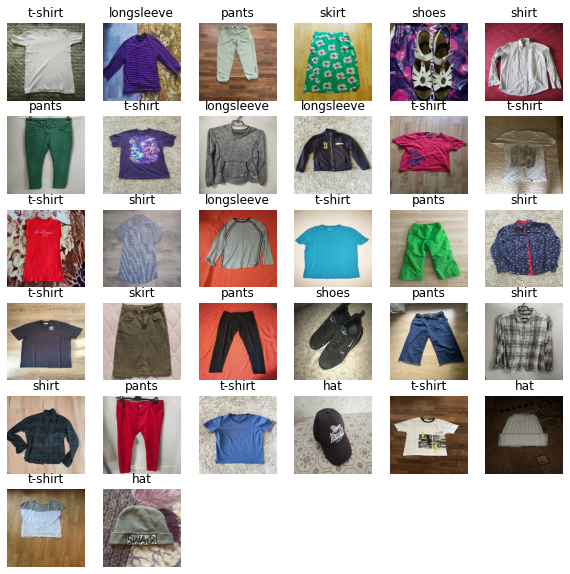

In [6]:
### To visualize the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(batch_size):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Plotting the images
plt.show()

In [7]:
img = cv2.imread('/content/drive/MyDrive/clothing-dataset-small-master/test/dress/06a00c0f-5f9a-410d-a7da-3881a9df3a71.jpg')

In [8]:
print(img)

[[[172 188 194]
  [172 188 194]
  [172 188 194]
  ...
  [175 196 198]
  [175 196 198]
  [175 196 198]]

 [[172 188 194]
  [172 188 194]
  [172 188 194]
  ...
  [175 196 198]
  [175 196 198]
  [175 196 198]]

 [[173 189 195]
  [173 189 195]
  [173 189 195]
  ...
  [177 196 199]
  [177 196 199]
  [177 196 199]]

 ...

 [[101 110 114]
  [101 110 114]
  [101 110 114]
  ...
  [ 99 107 114]
  [100 108 115]
  [100 108 115]]

 [[101 110 114]
  [101 110 114]
  [101 110 114]
  ...
  [ 99 107 114]
  [ 99 107 114]
  [ 99 107 114]]

 [[100 109 113]
  [100 109 113]
  [100 109 113]
  ...
  [100 108 115]
  [ 99 107 114]
  [ 97 105 112]]]


In [9]:
img.shape

(711, 400, 3)

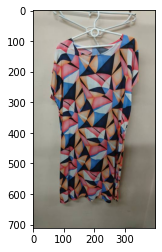

In [10]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [11]:
images[0]

<tf.Tensor: shape=(150, 150, 3), dtype=float32, numpy=
array([[[133.91055 , 135.91055 , 122.91055 ],
        [ 80.38333 ,  82.38333 ,  68.88333 ],
        [ 78.88833 ,  81.88833 ,  64.88833 ],
        ...,
        [109.86835 , 116.86835 , 100.86835 ],
        [ 97.28667 , 104.28667 ,  88.28667 ],
        [103.33406 , 110.33406 ,  94.33406 ]],

       [[104.441666, 106.441666,  93.441666],
        [ 75.745   ,  77.745   ,  64.245   ],
        [ 86.025   ,  89.025   ,  72.024994],
        ...,
        [ 94.36833 , 101.36833 ,  85.36833 ],
        [ 91.405   ,  98.405   ,  82.405   ],
        [103.626785, 110.626785,  94.626785]],

       [[ 85.15278 ,  87.15278 ,  74.15278 ],
        [ 83.85834 ,  85.85834 ,  72.35834 ],
        [ 99.85556 , 102.85556 ,  85.85556 ],
        ...,
        [ 94.016655, 101.016655,  85.016655],
        [ 87.85    ,  94.85    ,  78.85    ],
        [ 94.28342 , 101.28342 ,  85.28342 ]],

       ...,

       [[ 46.8472  ,  49.8472  ,  32.8472  ],
        [ 52.

In [12]:
labels[0]

<tf.Tensor: shape=(), dtype=int32, numpy=9>

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


This is a batch of 32 images, shape of 150x150 and 3 is the RGB color channel. label_batch specifies the labels of 32 images. 

# Configuring the dataset for performance



In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardization

Making the dataset values between the range f [0, 1]

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Creating a model

Creating a basic keras Sequential model with 3 convulation layers. maxPooling layer and the activation function relu.


In [17]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(10)
])

## Compiling the model

Optimizer choosen is adam and the loss function is tf.keras.losses.SparseCategoricalCrossentropy. Passing the metrics argument to view the training and test data accuracy.

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

## Training the model

In [20]:
history = model.fit(
  train_ds,
  epochs=10,
  validation_data=test_ds
)

Epoch 1/10
86/86 [==============================] - 171s 2s/step - loss: 1.9152 - accuracy: 0.3677 - val_loss: 1.4990 - val_accuracy: 0.5551
Epoch 2/10
86/86 [==============================] - 63s 737ms/step - loss: 1.3298 - accuracy: 0.5770 - val_loss: 1.2453 - val_accuracy: 0.6138
Epoch 3/10
86/86 [==============================] - 60s 694ms/step - loss: 0.9795 - accuracy: 0.6815 - val_loss: 1.1304 - val_accuracy: 0.6652
Epoch 4/10
86/86 [==============================] - 59s 690ms/step - loss: 0.7033 - accuracy: 0.7716 - val_loss: 1.1320 - val_accuracy: 0.6461
Epoch 5/10
86/86 [==============================] - 60s 697ms/step - loss: 0.5316 - accuracy: 0.8281 - val_loss: 1.1400 - val_accuracy: 0.6828
Epoch 6/10
86/86 [==============================] - 63s 729ms/step - loss: 0.3741 - accuracy: 0.8849 - val_loss: 1.3052 - val_accuracy: 0.6490
Epoch 7/10
86/86 [==============================] - 60s 694ms/step - loss: 0.2609 - accuracy: 0.9175 - val_loss: 1.4051 - val_accuracy: 0.6799
E

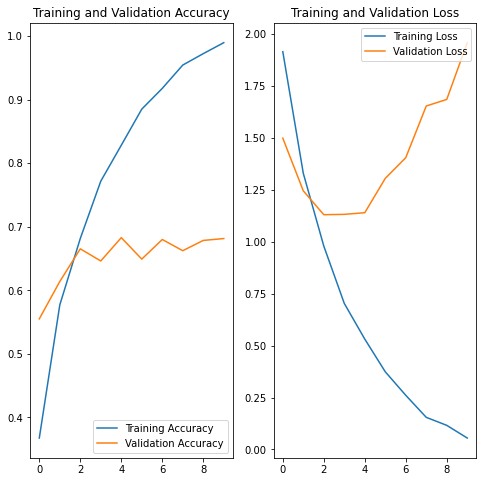

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

My model here has achieved 67% accuracy on the test data and 99% accuracy on the test data set. There is a very large difference between the train and test dataset. This clearly means that my model is overfitting. 

To deal with overfitting I am using data agumentation and add droupout to the model.


In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

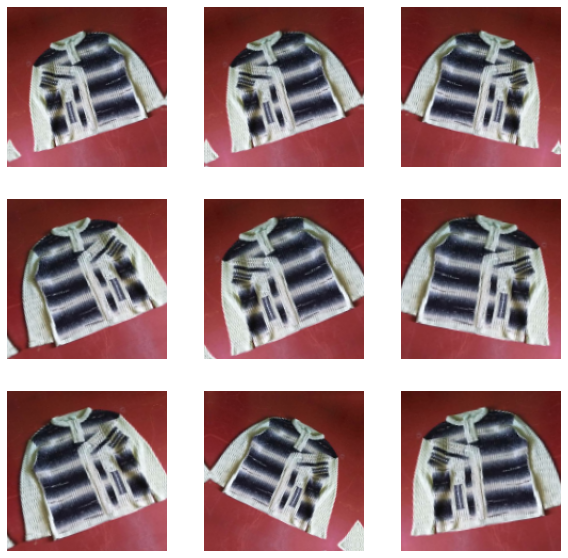

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

Compile and training the model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [27]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
86/86 [==============================] - 69s 792ms/step - loss: 2.0882 - accuracy: 0.2566 - val_loss: 1.9105 - val_accuracy: 0.3935
Epoch 2/15
86/86 [==============================] - 70s 814ms/step - loss: 1.7826 - accuracy: 0.4021 - val_loss: 1.5336 - val_accuracy: 0.5125
Epoch 3/15
86/86 [==============================] - 67s 776ms/step - loss: 1.5425 - accuracy: 0.4813 - val_loss: 1.3625 - val_accuracy: 0.5683
Epoch 4/15
86/86 [==============================] - 67s 774ms/step - loss: 1.4143 - accuracy: 0.5224 - val_loss: 1.3235 - val_accuracy: 0.5830
Epoch 5/15
86/86 [==============================] - 70s 815ms/step - loss: 1.3148 - accuracy: 0.5649 - val_loss: 1.3269 - val_accuracy: 0.5859
Epoch 6/15
86/86 [==============================] - 67s 778ms/step - loss: 1.2061 - accuracy: 0.6037 - val_loss: 1.1702 - val_accuracy: 0.6065
Epoch 7/15
86/86 [==============================] - 67s 779ms/step - loss: 1.1241 - accuracy: 0.6301 - val_loss: 1.1758 - val_accuracy: 0.6167

In [31]:
import pickle
with open('model.pkl', 'wb') as fid:
     pickle.dump(model, fid)

Visualize the results 

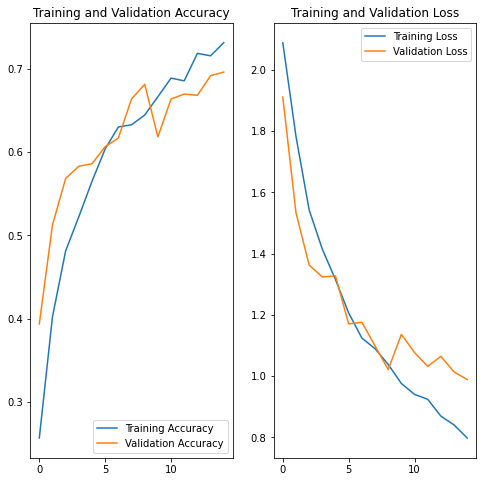

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## predicting for an image 

In [33]:
img = tf.keras.utils.load_img(
    '/content/drive/MyDrive/clothing-dataset-small-master/test/dress/28b09463-6bbb-491d-9ffc-f36df5c6b211.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 31ms/step
This image most likely belongs to dress with a 87.70 percent confidence.


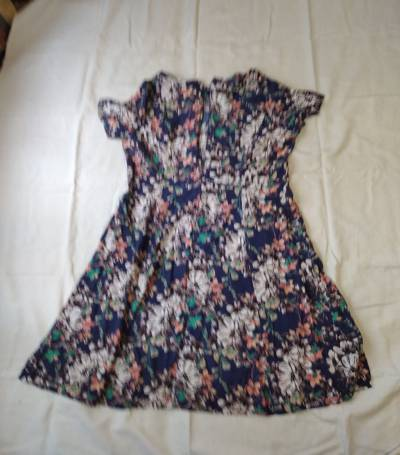

In [34]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/clothing-dataset-small-master/test/dress/28b09463-6bbb-491d-9ffc-f36df5c6b211.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [39]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 29.83 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [44]:
# import os
# import sys
# ROOT_DIR = os.path.abspath("../")

# import warnings
# warnings.filterwarnings("ignore")

# # Import Mask RCNN
# sys.path.append("Mask_RCNN/")   # To find local version of the library
# from Mask_RCNN.mrcnn import visualize
# import Mask_RCNN.mrcnn.model as modellib

In [45]:
img = tf.keras.utils.load_img(
    '/content/1595001411699.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 32ms/step
This image most likely belongs to shirt with a 45.27 percent confidence.


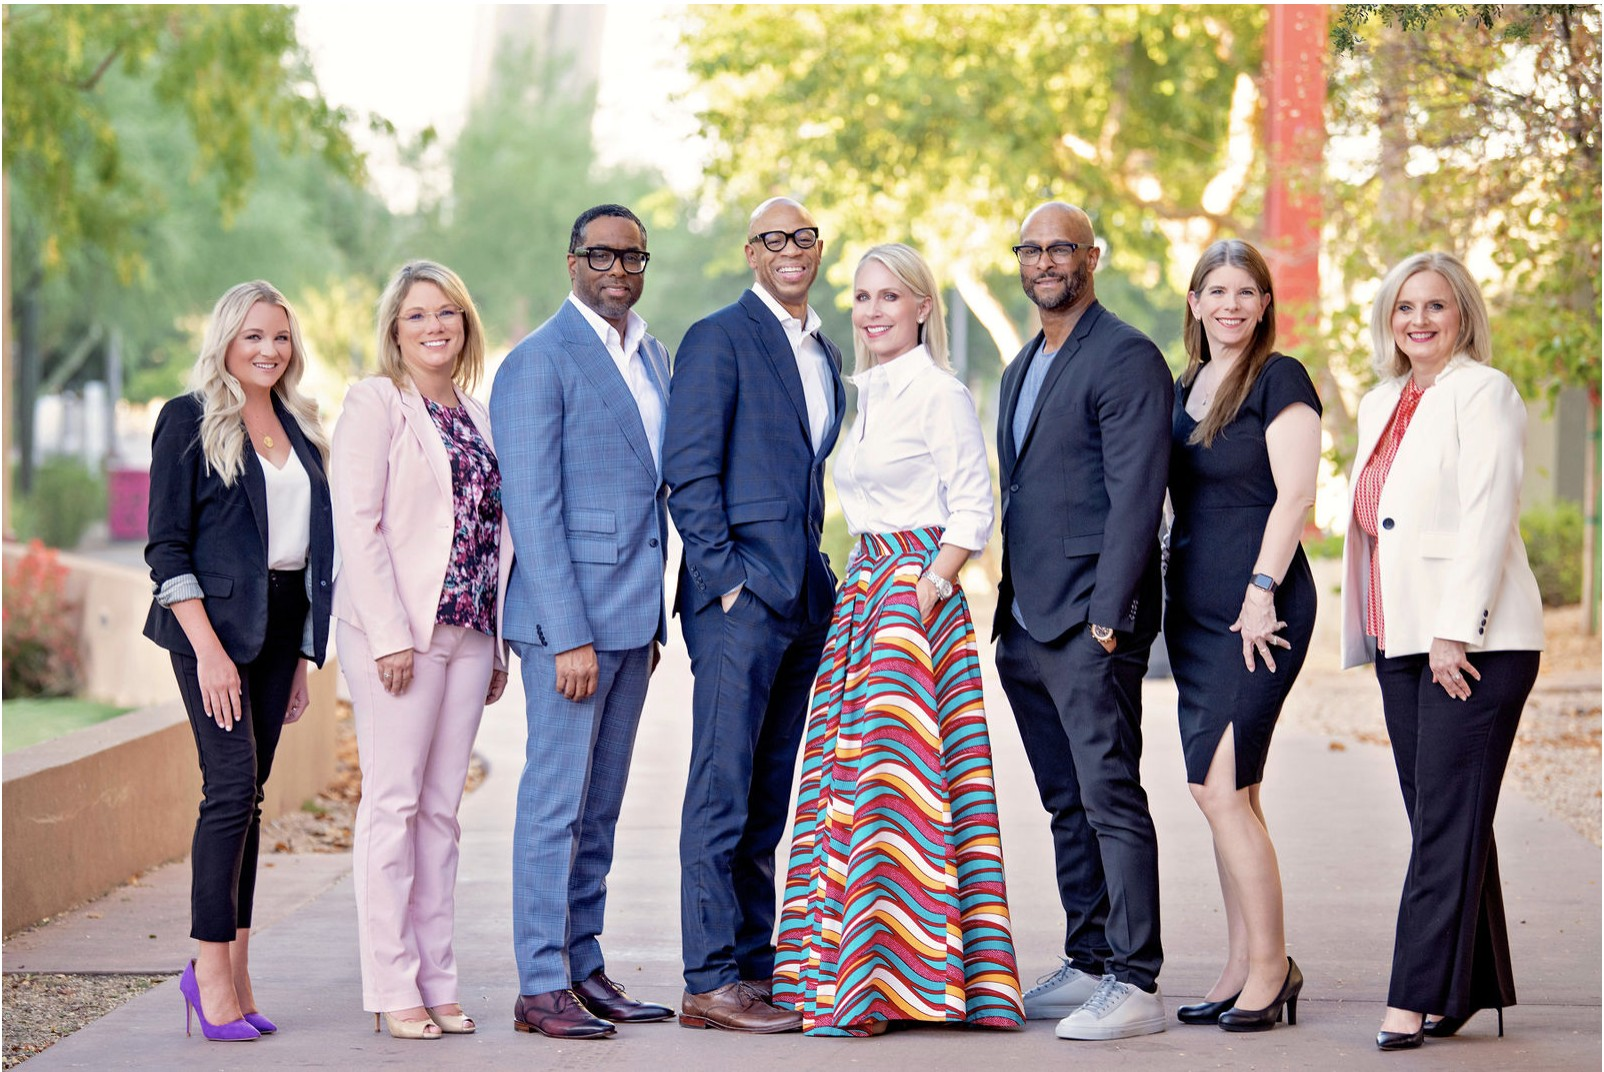

In [46]:
img = cv2.imread('/content/1595001411699.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [49]:
#/content/1595001411699.jpg
image = tf.keras.utils.load_img(
    '/content/1595001411699.jpg', target_size=(150, 150)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 40ms/step
This image most likely belongs to shirt with a 45.27 percent confidence.


In [57]:
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())


#The following GPU devices are available: /device:GPU:0

2.9.1
The following GPU devices are available: 


In [58]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [59]:
path='/content/1595001411699.jpg'
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [62]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

In [63]:
import time
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  81.71085286140442


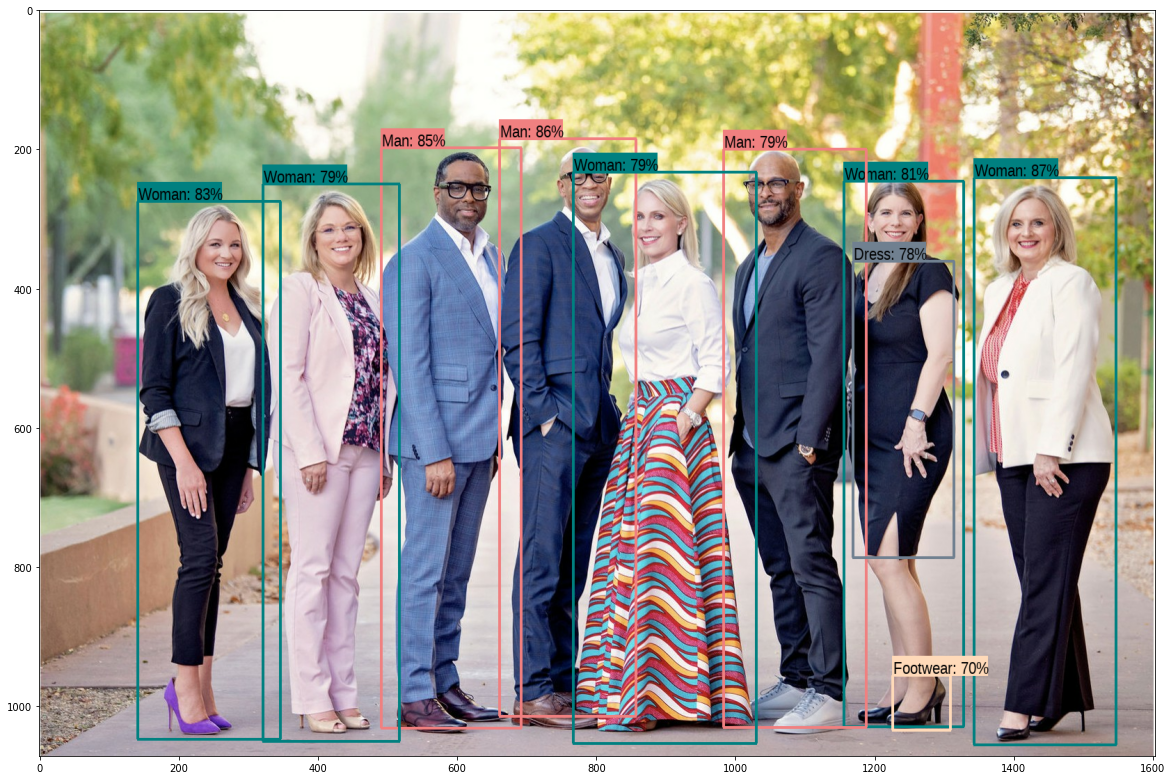

In [64]:
run_detector(detector, path)